In [10]:
from preprocess import cargar_y_preprocesar_datos
from utils import print_score
from sklearn.linear_model import LogisticRegression

In [11]:
ruta = "./data/credit_card_fraud_dataset.csv"
X_train, X_val, X_test, y_train, y_val, y_test = cargar_y_preprocesar_datos(ruta)

In [12]:
modelo_base = LogisticRegression(solver='liblinear')
modelo_base.fit(X_train, y_train)

print_score(modelo_base, X_train, y_train, X_val, y_val, train=True)
print_score(modelo_base, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 99.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0      1  accuracy     macro avg  weighted avg
precision      0.990000    0.0      0.99      0.495000      0.980100
recall         1.000000    0.0      0.99      0.500000      0.990000
f1-score       0.994975    0.0      0.99      0.497487      0.985025
support    59400.000000  600.0      0.99  60000.000000  60000.000000
_______________________________________________
Confusion Matrix: 
 [[59400     0]
 [  600     0]]

Test Result:
Accuracy Score: 99.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0      1  accuracy     macro avg  weighted avg
precision      0.990000    0.0      0.99      0.495000      0.980100
recall         1.000000    0.0      0.99      0.500000      0.990000
f1-score       0.994975    0.0      0.99      0.497487      0.985025
support    19800.000000  200.0      0.99  20000.000000  20000.00

c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

**El modelo base falló porque ignoró la clase minoritaria. Para corregirlo, usamos el hiperparámetro `class_weight='balanced'`, que penaliza más los errores cometidos en los casos de fraude, forzando al modelo a prestarles atención.**

In [13]:
from sklearn.linear_model import LogisticRegression

modelo_balanceado = LogisticRegression(class_weight='balanced', solver='liblinear')
modelo_balanceado.fit(X_train, y_train)

print_score(modelo_balanceado, X_train, y_train, X_val, y_val, train=True)
print_score(modelo_balanceado, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 51.26%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.991397    0.011462  0.512633      0.501429      0.981597
recall         0.512155    0.560000  0.512633      0.536077      0.512633
f1-score       0.675399    0.022464  0.512633      0.348932      0.668870
support    59400.000000  600.000000  0.512633  60000.000000  60000.000000
_______________________________________________
Confusion Matrix: 
 [[30422 28978]
 [  264   336]]

Test Result:
Accuracy Score: 50.66%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.991003    0.011026    0.5066      0.501014      0.981203
recall         0.506212    0.545000    0.5066      0.525606      0.506600
f1-score       0.670121    0.021614    0.5066      0.345868      0.663636
support    19800.00

#### **Encontrar el mejor umbral**
Usar la Curva Precision-Recall (PR).

El modelo actual está siendo **paranoico** porque usa el umbral por defecto de 0.5. Cualquier transacción con una probabilidad de fraude predicha de 0.5001 o más se marca como fraude. Dado que **class_weight** empuja las probabilidades hacia arriba, muchísimas transacciones legítimas superan ese umbral por poco. 

Solución: Sé más exigente. Solo marca una transacción como fraude si su probabilidad predicha es mucho más alta, por ejemplo, > 0.8 o > 0.9.

Cómo hacerlo:
 Obtén las probabilidades de fraude predichas para tu conjunto de validación.
- Visualiza cómo cambian la Precisión y el Recall a medida que mueves el umbral.
- Elige un nuevo umbral que te dé un equilibrio aceptable.

Mejor umbral según F1-score: 0.5450


C:\Users\Angelica\AppData\Local\Temp\ipykernel_20040\4228267505.py:10: RuntimeWarning: invalid value encountered in divide
  f1_scores = (2 * precisions * recalls) / (precisions + recalls)


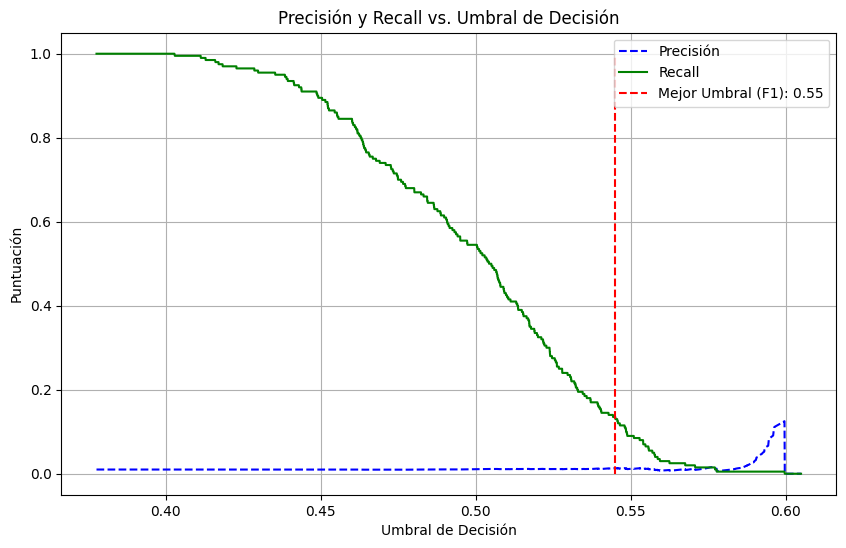


--- Resultados con el Umbral Optimizado (basado en F1) ---
[[17799  2001]
 [  173    27]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     19800
           1       0.01      0.14      0.02       200

    accuracy                           0.89     20000
   macro avg       0.50      0.52      0.48     20000
weighted avg       0.98      0.89      0.93     20000



In [14]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

y_scores = modelo_balanceado.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores) # ¡CORRECCIÓN! Debe ser y_val, no y_test

#umbral que maximiza el F1-score (un buen punto de partida)
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
# np.nanargmax devuelve el índice del valor máximo, ignorando los NaNs
best_threshold_f1 = thresholds[np.nanargmax(f1_scores)]
print(f"Mejor umbral según F1-score: {best_threshold_f1:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precisión")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.vlines(best_threshold_f1, 0, 1, color='red', linestyle='--', label=f'Mejor Umbral (F1): {best_threshold_f1:.2f}')
plt.xlabel("Umbral de Decisión")
plt.ylabel("Puntuación")
plt.legend()
plt.grid(True)
plt.title("Precisión y Recall vs. Umbral de Decisión")
plt.show()

#nuevo umbral para obtener nuevas predicciones
y_val_pred_nuevo_umbral = (y_scores >= best_threshold_f1).astype(int)

#evaluacion con el nuevo umbral
print("\n--- Resultados con el Umbral Optimizado (basado en F1) ---")
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_val_pred_nuevo_umbral))
print(classification_report(y_val, y_val_pred_nuevo_umbral))

**Técnicas para abordar el desbalanceo de clases**
- Submuestreo (Under-sampling:): La estrategia más simple es seleccionar al azar la clase mayoritaria para equilibrarla con la clase minoritaria. Pero la limitación es que los datos eliminados aleatoriamente de la clase mayoritaria pueden ser útiles para crear un modelo sólido.

- Sobremuestreo (Over-sampling): La forma más sencilla de sobremuestrear es duplicar datos en la clase minoritaria, pero no se agregará nueva información al modelo. Alternativamente, podemos sintetizar datos de los existentes, referidos como sobremuestreo de minorías sintéticas o SMOTE para abreviar. SMOTE funciona seleccionando datos cercanos o similares en el espacio de características y dibujando una línea entre los datos y creando nuevos datos en un punto de la línea. Es eficaz porque los datos nuevos están cerca de la clase minoritaria en el espacio de características. 

En este caso, el replicar en mayor medida las muestras más recientes de fraude provoca que el algoritmo sea capaz de tenerlas en cuenta en un corto plazo desde que se comienzan a realizar, pero como se tienen demasiados datos de la clase 0 hay que eliminar algunos (undersampling).

In [15]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from utils import print_score 
import pandas as pd

#El parámetro `random_state` es para que la creación de datos sintéticos sea reproducible
smote = SMOTE(random_state=42)

print("--- Antes de SMOTE ---")
print("Forma de X_train:", X_train.shape)
print("Distribución de clases en y_train:\n", y_train.value_counts())

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\n--- Después de SMOTE ---")
print("Forma de X_train remuestreado:", X_train_resampled.shape)
print("Distribución de clases en y_train remuestreado:\n", y_train_resampled.value_counts())

modelo_smote_manual = LogisticRegression(solver='liblinear')

print("\nEntrenando el modelo con los datos remuestreados...")
modelo_smote_manual.fit(X_train_resampled, y_train_resampled)

print("\n--- Resultados del Modelo en el set de Entrenamiento (Remuestreado) ---")
print_score(modelo_smote_manual, X_train_resampled, y_train_resampled, X_train_resampled, y_train_resampled, train=True)

print("\n--- Resultados del Modelo en el set de Validación (Original) ---")
print_score(modelo_smote_manual, X_train_resampled, y_train_resampled, X_val, y_val, train=False)

--- Antes de SMOTE ---
Forma de X_train: (60000, 15)
Distribución de clases en y_train:
 IsFraud
0    59400
1      600
Name: count, dtype: int64

--- Después de SMOTE ---
Forma de X_train remuestreado: (118800, 15)
Distribución de clases en y_train remuestreado:
 IsFraud
0    59400
1    59400
Name: count, dtype: int64

Entrenando el modelo con los datos remuestreados...

--- Resultados del Modelo en el set de Entrenamiento (Remuestreado) ---
Train Result:
Accuracy Score: 83.87%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.757643      0.994008  0.838662       0.875825       0.875825
recall         0.995892      0.681431  0.838662       0.838662       0.838662
f1-score       0.860582      0.808562  0.838662       0.834572       0.834572
support    59400.000000  59400.000000  0.838662  118800.000000  118800.000000
_______________________________________________
Confusio

**Presencia de sobreajuste inducido por SMOTE**

Resultados de Entrenamiento: El modelo se **memorizó** perfectamente las características de los datos sintéticos creados por SMOTE. 

Resultados de Validación: No detectó ni un solo fraude real (Verdaderos Positivos = 0). El conocimiento que el modelo adquirió de los datos sintéticos fue inútil para identificar los fraudes reales. Los fraudes reales eran lo suficientemente diferentes de los sintéticos como para que el modelo no los reconociera. Se sobreajustó por completo.

**Combinar Sobremuestreo (SMOTE) con Submuestreo**

SMOTE puede crear **ruido**, puede generar ejemplos sintéticos en zonas donde las clases se solapan mucho. El submuestreo, aplicado después, puede ayudar a limpiar esas zonas eliminando ejemplos de la clase mayoritaria que son problemáticos o que están demasiado cerca de la minoritaria, creando una frontera de decisión más clara.

La técnica más conocida que hace esto es **SMOTEENN**.
- **SMOTE:** Primero, crea los datos sintéticos de la clase minoritaria.
- **ENN (Edited Nearest Neighbours):** Después, es un algoritmo de limpieza (un tipo de submuestreo) que elimina cualquier ejemplo (de cualquier clase) que sea clasificado incorrectamente por sus vecinos más cercanos. Esto ayuda a eliminar el ruido de la frontera.

In [16]:
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN
from utils import print_score 

smote_enn = SMOTEENN(random_state=42)

print("--- Antes de SMOTEENN ---")
print("Forma de X_train:", X_train.shape)
print("Distribución de clases en y_train:\n", y_train.value_counts())

X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# OJO: A diferencia de SMOTE, las clases no quedarán perfectamente 50/50.
# SMOTE primero iguala las clases y luego ENN elimina ejemplos de AMBAS clases
# para limpiar la frontera, por lo que el conteo final puede ser ligeramente desigual.
print("\n--- Después de SMOTEENN ---")
print("Forma de X_train remuestreado:", X_train_resampled.shape)
print("Distribución de clases en y_train remuestreado:\n", y_train_resampled.value_counts())

modelo_smoteenn_manual = LogisticRegression(solver='liblinear')

print("\nEntrenando el modelo con los datos remuestreados por SMOTEENN...")
modelo_smoteenn_manual.fit(X_train_resampled, y_train_resampled)

print("\n--- Resultados del Modelo en el set de Entrenamiento (Remuestreado por SMOTEENN) ---")
print_score(modelo_smoteenn_manual, X_train_resampled, y_train_resampled, X_train_resampled, y_train_resampled, train=True)

print("\n--- Resultados del Modelo en el set de Validación (Original) ---")
print_score(modelo_smoteenn_manual, X_train_resampled, y_train_resampled, X_val, y_val, train=False)

--- Antes de SMOTEENN ---
Forma de X_train: (60000, 15)
Distribución de clases en y_train:
 IsFraud
0    59400
1      600
Name: count, dtype: int64



--- Después de SMOTEENN ---
Forma de X_train remuestreado: (112683, 15)
Distribución de clases en y_train remuestreado:
 IsFraud
1    59371
0    53312
Name: count, dtype: int64

Entrenando el modelo con los datos remuestreados por SMOTEENN...

--- Resultados del Modelo en el set de Entrenamiento (Remuestreado por SMOTEENN) ---
Train Result:
Accuracy Score: 82.81%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.739476      0.978193  0.828075       0.858835       0.865253
recall         0.982893      0.689057  0.828075       0.835975       0.828075
f1-score       0.843984      0.808554  0.828075       0.826269       0.825316
support    53312.000000  59371.000000  0.828075  112683.000000  112683.000000
_______________________________________________
Confusion Matrix: 
 [[52400   912]
 [18461 40910]]


--- Resultados del Modelo en el set de Validación (Original) ---
Test R

Hasta ahora el experimento que mejor ha funcionado ha sido con **class_weight** vamos a mejorarlo

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from utils import print_score 

log_reg = LogisticRegression(class_weight='balanced', solver='liblinear')

# Definir el espacio de búsqueda de hiperparámetros
# Probaremos diferentes valores para 'C', que controla la regularización
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] 
}

# Definir la métrica de evaluación
# Usamos el F1-score para la clase de fraude (1) porque busca un equilibrio 
# entre Precisión y Recall, que es exactamente lo que queremos.
f1_scorer = make_scorer(f1_score, pos_label=1)

# Configurar la Búsqueda en Rejilla (Grid Search)
# cv=5 significa que usará validación cruzada con 5 pliegues.
grid_search = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid, 
    scoring=f1_scorer, 
    cv=5,
    n_jobs=-1 # Usa todos los procesadores
)
# Ejecutar la búsqueda en los datos de entrenamiento
print("--- Buscando la mejor combinación de 'C' y 'class_weight' ---")
grid_search.fit(X_train, y_train)

print(f"\nMejor parámetro encontrado: {grid_search.best_params_}")
print(f"Mejor puntuación F1 (en validación cruzada): {grid_search.best_score_:.4f}")

# Obtener el mejor modelo encontrado
best_logistic_model = grid_search.best_estimator_

# Evaluar este "mejor modelo" final en nuestro set de validación
print("\n--- Resultados del Mejor Modelo de Regresión Logística en el set de Validación ---")
print_score(best_logistic_model, X_train, y_train, X_val, y_val, train=False)

--- Buscando la mejor combinación de 'C' y 'class_weight' ---



Mejor parámetro encontrado: {'C': 0.001}
Mejor puntuación F1 (en validación cruzada): 0.0187

--- Resultados del Mejor Modelo de Regresión Logística en el set de Validación ---
Test Result:
Accuracy Score: 53.75%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.990789    0.010917    0.5375      0.500853       0.98099
recall         0.537828    0.505000    0.5375      0.521414       0.53750
f1-score       0.697198    0.021371    0.5375      0.359284       0.69044
support    19800.000000  200.000000    0.5375  20000.000000   20000.00000
_______________________________________________
Confusion Matrix: 
 [[10649  9151]
 [   99   101]]

